In [0]:
! pip install tensorflow
! pip install keras

In [0]:
import os
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
#from tensorflow import set_random_seed
import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from keras.layers import GaussianNoise

In [0]:
storage_account_name = "stmvpdata001"
storage_account_access_key = "ow925GFosNhRfc5geD+N23aBAdVNB1uDBG2L/TcL7KTX+/b/bXYr+dEEOGf2wGujKgS5O6Ntg2f0bEruq71EMA=="
file_location = "wasbs://connacher-extract@stmvpdata001.blob.core.windows.net/Algar/2019/08/080801.FIT_12803.VALUE_August2019.csv"
file_type = "csv"
spark.conf.set("fs.azure.account.key."+storage_account_name+".blob.core.windows.net",storage_account_access_key)
df = spark.read.format(file_type).option("inferSchema", "true").load(file_location, header = None)

In [0]:
df=df.toPandas()

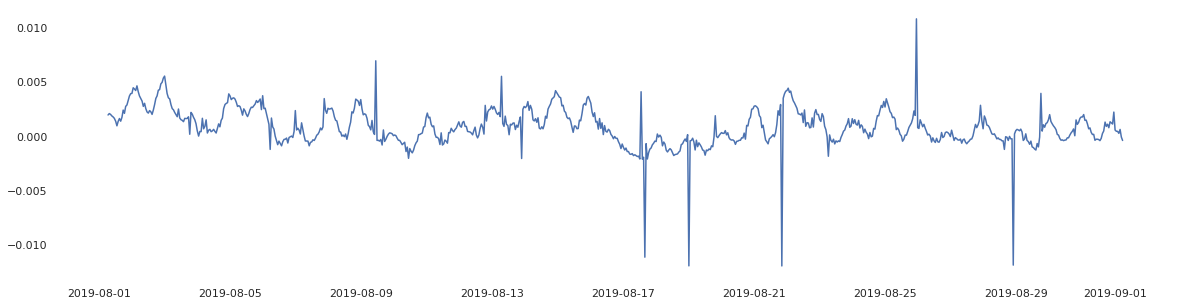

In [0]:
#'080801.FIT_12803.VALUE','5Min'
def anomaly_preprocessing(dataframe, tag, resample_time):
  import matplotlib
  df_renamed = dataframe.rename(columns = {'_c0': 'tagname', '_c1':'time','_c2': 'flow'}, inplace = False)
  df_hist=df_renamed.copy()
  df_hist = df_hist.set_index('tagname')   
  df_hist = df_hist.replace("NULL", 0)
  df_hist['flow'] = df_hist.flow.astype(float)
  df_hist['time'] = pd.to_datetime(df_hist.time)
  df_hist=df_hist.loc[tag]
  df_hist=df_hist.reset_index()
  df_hist_tag_removed = df_hist.drop(columns = 'tagname')
  df_hist_resampled = df_hist_tag_removed.resample(resample_time, on='time').flow.median()
  df_hist_resampled=df_hist_resampled.to_frame()
  anomaly_preprocessing.df_hist_resampled=df_hist_resampled.dropna()
  fig,ax = plt.subplots(figsize=(20,5))
  fig.patch.set_facecolor('xkcd:white')
  ax.set_facecolor('xkcd:white')
  matplotlib.rc('xtick', labelsize=20) 
  matplotlib.rc('ytick', labelsize=20)
  ax.plot(anomaly_preprocessing.df_hist_resampled)
anomaly_preprocessing(df, '080801.FIT_12803.VALUE', '5Min')

In [0]:
def anomaly_detection(dataframe):
  anomaly_detection.train = dataframe['2019-08-01 00:00:00': '2019-09-20 23:00:00']
  anomaly_detection.test = dataframe['2019-08-21 00:00:00':'2019-09-01 23:00:00']
  anomaly_detection.rolling = anomaly_detection.train.rolling(window = 12)
  anomaly_detection.rolling_median = anomaly_detection.rolling.median()
  anomaly_detection.rolling_median_na_dropped = anomaly_detection.rolling_median.dropna()
  anomaly_detection.train_normal = anomaly_detection.rolling_median_na_dropped[np.abs(anomaly_detection.rolling_median_na_dropped.flow -      anomaly_detection.rolling_median_na_dropped.flow.mean()) <= (2*anomaly_detection.rolling_median_na_dropped.flow.std())]
anomaly_detection(anomaly_preprocessing.df_hist_resampled)  

In [0]:
def modelling_1(time_steps, train_normal):
  # normalize the data
  from sklearn.preprocessing import StandardScaler
  modelling_1.scaler = StandardScaler()
  modelling_1.scaler = modelling_1.scaler.fit(anomaly_detection.train_normal[['flow']])
  train_normal['flow'] = modelling_1.scaler.transform(anomaly_detection.train_normal[['flow']])
  anomaly_detection.test['flow'] = modelling_1.scaler.transform(anomaly_detection.test[['flow']])
  def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
  modelling_1.TIME_STEPS = time_steps 
  modelling_1.X_train, modelling_1.y_train = create_dataset(
    anomaly_detection.train_normal[['flow']],
    anomaly_detection.train_normal.flow,
    modelling_1.TIME_STEPS
  )

  modelling_1.X_test, modelling_1.y_test = create_dataset(
    anomaly_detection.test[['flow']],
    anomaly_detection.test.flow,
    modelling_1.TIME_STEPS
  )

  print(modelling_1.X_train.shape)
  print(modelling_1.X_test.shape)
modelling_1(4, anomaly_detection.train_normal)

/local_disk0/tmp/1611120649347-0/PythonShell.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import os
/local_disk0/tmp/1611120649347-0/PythonShell.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import pickle
(753, 4, 1)
(290, 4, 1)

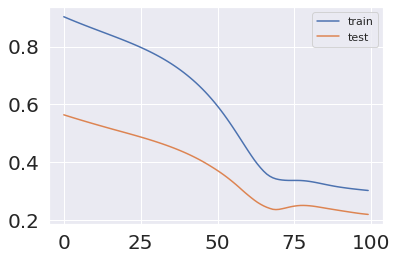

In [0]:
def modelling_2():
  modelling_2.model = keras.Sequential()
  modelling_2.model.add(keras.layers.LSTM(
      units=16,
      input_shape=(modelling_1.X_train.shape[1], modelling_1.X_train.shape[2])
  ))
  modelling_2.model.add(keras.layers.RepeatVector(n=modelling_1.X_train.shape[1]))
  modelling_2.model.add(keras.layers.LSTM(units=16, return_sequences=True))
  modelling_2.model.add(
    keras.layers.TimeDistributed(
      keras.layers.Dense(units=modelling_1.X_train.shape[2])
    )
  )

  modelling_2.model.compile(loss='mae', optimizer='adam')
  #model.fit(X_train, X_train, epochs=100, batch_size=6000, verbose=1, validation_data=(X_test, y_test))
  history = modelling_2.model.fit(
      modelling_1.X_train, modelling_1.X_train,
      epochs=100,
      batch_size=1024,
      validation_split=0.1,
      shuffle=False
  )
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend();
modelling_2()

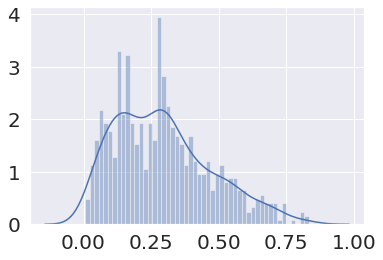

In [0]:
def modelling_3():
  modelling_3.X_train_pred = modelling_2.model.predict(modelling_1.X_train)
  modelling_3.train_mae_loss = np.mean(np.abs(modelling_3.X_train_pred - modelling_1.X_train), axis=1)
  sns.distplot(modelling_3.train_mae_loss, bins=50, kde=True);
modelling_3()

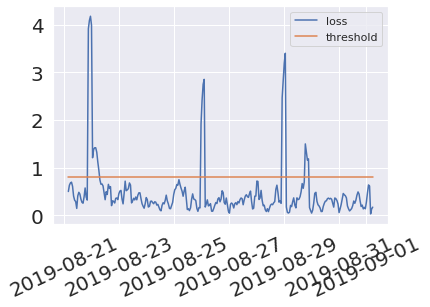

In [0]:
def modelling_4(threshold):  
  modelling_4.X_test_pred = modelling_2.model.predict(modelling_1.X_test)
  modelling_4.test_mae_loss = np.mean(np.abs(modelling_4.X_test_pred - modelling_1.X_test), axis=1)
  modelling_4.THRESHOLD = threshold

  modelling_4.test_score_df = pd.DataFrame(index=anomaly_detection.test[modelling_1.TIME_STEPS:].index)
  modelling_4.test_score_df['loss'] = modelling_4.test_mae_loss
  modelling_4.test_score_df['threshold'] = threshold
  modelling_4.test_score_df['anomaly'] = modelling_4.test_score_df.loss > modelling_4.test_score_df.threshold
  modelling_4.test_score_df['flow'] = anomaly_detection.test[modelling_1.TIME_STEPS:].flow
  plt.plot(modelling_4.test_score_df.index, modelling_4.test_score_df.loss, label='loss')
  plt.plot(modelling_4.test_score_df.index, modelling_4.test_score_df.threshold, label='threshold')
  plt.xticks(rotation=25)
  plt.legend();
modelling_4(0.8)

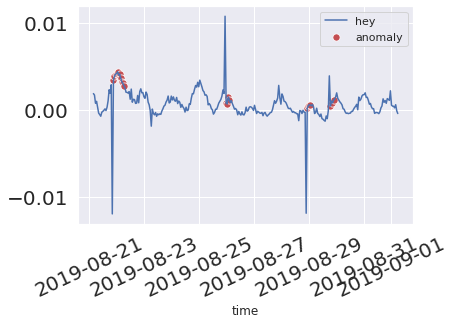

In [0]:
def plot_anomaly(tag,TIME_STEPS):
  plot_anomaly.anomalies = modelling_4.test_score_df[modelling_4.test_score_df.anomaly == True]
  plt.plot(
    anomaly_detection.test[modelling_1.TIME_STEPS:].index, 
    modelling_1.scaler.inverse_transform(anomaly_detection.test[modelling_1.TIME_STEPS:].flow), 
    label=tag
  );
  sns.scatterplot(
    plot_anomaly.anomalies.index,
    modelling_1.scaler.inverse_transform(plot_anomaly.anomalies.flow),
    color=sns.color_palette()[3],
    s=52,
    label='anomaly'
  )
  plt.xticks(rotation=25)
  plt.legend();
plot_anomaly('hey',modelling_1.TIME_STEPS)